# Data Exploration for Evacuation Route Optimization

This notebook demonstrates how to collect and explore various data sources used in the evacuation route optimization project.

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import osmnx as ox
import networkx as nx
import folium
import requests
from pathlib import Path

# Add project root to path
sys.path.append('..')
from config import RAW_DATA_DIR, PROCESSED_DATA_DIR, OPENWEATHERMAP_API_KEY

## 1. OpenStreetMap Data Collection and Exploration

First, let's download and explore the road network data from OpenStreetMap.

In [2]:
# Define the city to analyze
city = "Paris, France"

# Download the road network
G = ox.graph_from_place(city, network_type='drive')

# Basic statistics
print(f"Number of nodes: {len(G.nodes)}")
print(f"Number of edges: {len(G.edges)}")

Number of nodes: 9475
Number of edges: 18237


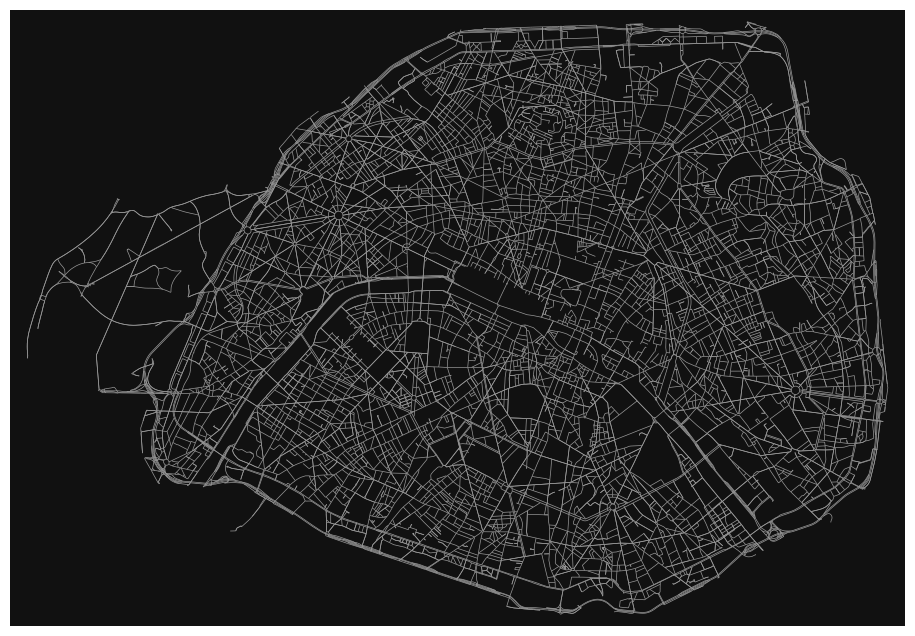

In [3]:
# Plot the network
fig, ax = ox.plot_graph(G, figsize=(12, 8), node_size=0, edge_linewidth=0.5)

In [4]:
# Convert the graph to GeoDataFrames
nodes, edges = ox.graph_to_gdfs(G)

# Display the first few rows of the nodes DataFrame
nodes.head()

,y,x,street_count,highway,junction,railway,ref,geometry
osmid,,,,,,,,
125730,48.863523,2.410732,4,NaN,NaN,NaN,NaN,POINT (2.41073 48.86352)
125742,48.851852,2.401373,4,NaN,NaN,NaN,NaN,POINT (2.40137 48.85185)
125743,48.854563,2.413409,3,NaN,NaN,NaN,NaN,POINT (2.41341 48.85456)
125745,48.854524,2.414352,3,NaN,NaN,NaN,NaN,POINT (2.41435 48.85452)
125747,48.854261,2.414664,3,NaN,NaN,NaN,NaN,POINT (2.41466 48.85426)


In [5]:
# Display the first few rows of the edges DataFrame
edges.head()

osmid      highway lanes maxspeed  \
u      v           key                                                       
125730 12179625841 0                  31093720  residential     2       30   
       244455548   0                  85735969  residential     2       30   
       567367734   0                 315818975  residential   NaN       30   
       1089076182  0    [266463585, 611974677]  residential     2       30   
125742 60912980    0                   4039102  residential   NaN       30   

                                       name  oneway reversed      length  \
u      v           key                                                     
125730 12179625841 0      Rue Louis Lumière   False    False    4.347747   
       244455548   0      Rue Louis Lumière   False     True  105.925927   
       567367734   0    Rue Henri Duvernois   False     True   35.154556   
       1089076182  0        Rue Louis Ganne   False     True  128.654471   
125742 60912980    0        Rue de Buzenval    True    False  129.018946   

                                                                 geometry  \
u      v           key                                                      
125730 12179625841 0      LINESTRING (2.41073 48.86352, 2.41072 48.86356)   
       244455548   0    LINESTRING (2.41073 48.86352, 2.41077 48.86337...   
       567367734   0    LINESTRING (2.41073 48.86352, 2.41083 48.86348...   
       1089076182  0    LINESTRING (2.41073 48.86352, 2.41062 48.86351...   
125742 60912980    0    LINESTRING (2.40137 48.85185, 2.40133 48.85192...   

                       junction width bridge tunnel access  ref  
u      v           key                                           
125730 12179625841 0        NaN   NaN    NaN    NaN    NaN  NaN  
       244455548   0        NaN   NaN    NaN    NaN    NaN  NaN  
       567367734   0        NaN   NaN    NaN    NaN    NaN  NaN  
       1089076182  0        NaN   NaN    NaN    NaN    NaN  NaN  
125742 60912980    0        NaN   NaN    NaN    NaN    NaN  NaN

## 2. Weather Data Collection and Exploration

Now, let's collect and analyze weather data from OpenWeatherMap.

In [7]:
# Define the API endpoint for current weather
url = f"https://api.openweathermap.org/data/2.5/weather?q={city.split(',')[0]}&appid={OPENWEATHERMAP_API_KEY}&units=metric"

# Make the API request
response = requests.get(url)
weather_data = response.json()

# Check if the API returned an error
if 'cod' in weather_data and weather_data['cod'] != 200:
    print(f"Error: {weather_data.get('message', 'Unknown error')}")
    print(f"Response code: {weather_data.get('cod', 'Unknown')}")
    print("Full response:", weather_data)
else:
    # Print the weather data if successful
    print(f"Temperature: {weather_data['main']['temp']}°C")
    print(f"Humidity: {weather_data['main']['humidity']}%")
    print(f"Wind Speed: {weather_data['wind']['speed']} m/s")
    print(f"Weather: {weather_data['weather'][0]['main']} - {weather_data['weather'][0]['description']}")

Error: Invalid API key. Please see https://openweathermap.org/faq#error401 for more info.
Response code: 401
Full response: {'cod': 401, 'message': 'Invalid API key. Please see https://openweathermap.org/faq#error401 for more info.'}


In [ ]:
# Define the API endpoint for 5-day forecast
forecast_url = f"https://api.openweathermap.org/data/2.5/forecast?q={city.split(',')[0]}&appid={OPENWEATHERMAP_API_KEY}&units=metric"

# Make the API request
forecast_response = requests.get(forecast_url)
forecast_data = forecast_response.json()

# Extract forecast data points
forecast_times = []
forecast_temps = []
forecast_precip = []

for item in forecast_data['list']:
    forecast_times.append(pd.to_datetime(item['dt_txt']))
    forecast_temps.append(item['main']['temp'])
    # Rain data might not be present in all forecasts
    if 'rain' in item and '3h' in item['rain']:
        forecast_precip.append(item['rain']['3h'])
    else:
        forecast_precip.append(0)

# Create a DataFrame for the forecast
forecast_df = pd.DataFrame({
    'time': forecast_times,
    'temperature': forecast_temps,
    'precipitation': forecast_precip
})

In [ ]:
# Plot the temperature forecast
plt.figure(figsize=(12, 6))
plt.plot(forecast_df['time'], forecast_df['temperature'], 'r-', linewidth=2)
plt.title('Temperature Forecast')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Plot the precipitation forecast
plt.figure(figsize=(12, 6))
plt.bar(forecast_df['time'], forecast_df['precipitation'], color='blue', alpha=0.7)
plt.title('Precipitation Forecast (3-hour)')
plt.xlabel('Time')
plt.ylabel('Precipitation (mm)')
plt.grid(True, axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 3. Simulating Hazard Data

For demonstration purposes, let's simulate some hazard data to overlay on the map.

In [ ]:
# Get the bounding box of the city
bbox = ox.utils_geo.bbox_from_point(
    (G.nodes[list(G.nodes)[0]]['y'], G.nodes[list(G.nodes)[0]]['x']),
    dist=10000  # 10 km
)
north, south, east, west = bbox

In [ ]:
# Function to create a random polygon
def create_random_polygon(center_lat, center_lon, radius=0.01, num_points=8):
    # Generate random points around the center
    angles = np.linspace(0, 2*np.pi, num_points, endpoint=False)
    distances = np.random.uniform(0.5*radius, radius, num_points)
    
    # Calculate coordinates
    lats = center_lat + distances * np.sin(angles)
    lons = center_lon + distances * np.cos(angles)
    
    # Close the polygon
    lats = np.append(lats, lats[0])
    lons = np.append(lons, lons[0])
    
    return list(zip(lats, lons))

In [ ]:
# Create simulated hazard data
num_hazards = 5
hazard_types = ['flood', 'fire', 'storm', 'chemical', 'landslide']
hazard_data = []

for i in range(num_hazards):
    # Random center point within the bounding box
    center_lat = np.random.uniform(south, north)
    center_lon = np.random.uniform(west, east)
    
    # Random hazard type and severity
    hazard_type = hazard_types[i % len(hazard_types)]
    severity = np.random.uniform(0.3, 0.9)
    
    # Create polygon for the hazard area
    polygon = create_random_polygon(center_lat, center_lon, radius=0.02)
    
    hazard_data.append({
        'type': hazard_type,
        'severity': severity,
        'coordinates': polygon
    })

In [ ]:
# Create a map to visualize the hazards
center_lat = (north + south) / 2
center_lon = (east + west) / 2

m = folium.Map(location=[center_lat, center_lon], zoom_start=12)

# Add the road network
for u, v, data in G.edges(data=True):
    points = [(G.nodes[u]['y'], G.nodes[u]['x']), (G.nodes[v]['y'], G.nodes[v]['x'])]
    folium.PolyLine(points, color='gray', weight=1, opacity=0.7).add_to(m)

# Add hazard areas
for hazard in hazard_data:
    # Choose color based on hazard type
    if hazard['type'] == 'flood':
        color = 'blue'
    elif hazard['type'] == 'fire':
        color = 'red'
    elif hazard['type'] == 'storm':
        color = 'purple'
    elif hazard['type'] == 'chemical':
        color = 'green'
    else:  # landslide
        color = 'brown'
    
    # Add polygon
    folium.Polygon(
        locations=hazard['coordinates'],
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.4,
        weight=2,
        popup=f"{hazard['type'].capitalize()} - Severity: {hazard['severity']:.2f}"
    ).add_to(m)

m

## 4. Pathfinding and Route Optimization

Let's demonstrate how to calculate evacuation routes using our A* algorithm.

In [ ]:
# Import the pathfinding module
from src.optimization.pathfinding import AStarPathfinder

In [ ]:
# Assign risk values to the road network based on simulated hazards
# Convert hazard polygons to GeoDataFrames for spatial operations
from shapely.geometry import Polygon, LineString, Point

# Create GeoDataFrame for hazards
hazard_polygons = []
hazard_types = []
hazard_severities = []

for hazard in hazard_data:
    # Convert coordinates to shapely Polygon
    polygon = Polygon([(lon, lat) for lat, lon in hazard['coordinates']])
    hazard_polygons.append(polygon)
    hazard_types.append(hazard['type'])
    hazard_severities.append(hazard['severity'])

hazard_gdf = gpd.GeoDataFrame({
    'type': hazard_types,
    'severity': hazard_severities,
    'geometry': hazard_polygons
})

In [ ]:
# Assign risk values to each edge based on intersection with hazard areas
for u, v, key, data in G.edges(data=True, keys=True):
    # Extract the geometry of the edge
    if 'geometry' in data:
        # If geometry exists, use it directly
        edge_geom = data['geometry']
    else:
        # Otherwise, create a LineString from the nodes
        edge_geom = LineString([(G.nodes[u]['x'], G.nodes[u]['y']), (G.nodes[v]['x'], G.nodes[v]['y'])])
    
    # Calculate risk based on intersections with hazards
    risk = 0.0
    
    for idx, hazard in hazard_gdf.iterrows():
        if edge_geom.intersects(hazard.geometry):
            # If the edge intersects a hazard area, add to the risk based on severity
            risk += hazard.severity
    
    # Normalize risk to [0, 1] if it exceeds 1
    risk = min(risk, 1.0)
    
    # Assign the risk to the edge
    G[u][v][key]['risk'] = risk

In [ ]:
# Find a route between two points using A* algorithm
# First, select two random nodes as start and end points
all_nodes = list(G.nodes())
start_node = all_nodes[np.random.randint(0, len(all_nodes))]
end_node = all_nodes[np.random.randint(0, len(all_nodes))]

# Make sure start and end nodes are different
while end_node == start_node:
    end_node = all_nodes[np.random.randint(0, len(all_nodes))]

In [ ]:
# Initialize the pathfinder
pathfinder = AStarPathfinder(risk_weight=0.7, time_weight=0.3)

# Find the optimal path
path, cost = pathfinder.find_path(G, start_node, end_node)

if path:
    print(f"Found path with {len(path)} nodes and cost {cost:.2f}")
else:
    print("No path found between the selected nodes.")

In [ ]:
# Find alternative paths
alt_paths = pathfinder.find_multiple_paths(G, start_node, end_node, num_paths=3)

print(f"Found {len(alt_paths)} alternative paths")
for i, (path, cost) in enumerate(alt_paths):
    print(f"Path {i+1}: {len(path)} nodes, cost {cost:.2f}")

In [ ]:
# Visualize the paths on a map
m = folium.Map(location=[center_lat, center_lon], zoom_start=12)

# Add the road network
for u, v, data in G.edges(data=True):
    points = [(G.nodes[u]['y'], G.nodes[u]['x']), (G.nodes[v]['y'], G.nodes[v]['x'])]
    folium.PolyLine(points, color='gray', weight=1, opacity=0.5).add_to(m)

# Add hazard areas
for hazard in hazard_data:
    # Choose color based on hazard type
    if hazard['type'] == 'flood':
        color = 'blue'
    elif hazard['type'] == 'fire':
        color = 'red'
    elif hazard['type'] == 'storm':
        color = 'purple'
    elif hazard['type'] == 'chemical':
        color = 'green'
    else:  # landslide
        color = 'brown'
    
    # Add polygon
    folium.Polygon(
        locations=hazard['coordinates'],
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.4,
        weight=2,
        popup=f"{hazard['type'].capitalize()} - Severity: {hazard['severity']:.2f}"
    ).add_to(m)

# Add the paths
colors = ['blue', 'red', 'green']
for i, (path, cost) in enumerate(alt_paths):
    # Extract coordinates for the path
    path_coords = []
    for node in path:
        path_coords.append((G.nodes[node]['y'], G.nodes[node]['x']))
    
    # Add the path to the map
    folium.PolyLine(
        path_coords,
        color=colors[i % len(colors)],
        weight=4,
        opacity=0.8,
        popup=f"Path {i+1}: Cost {cost:.2f}"
    ).add_to(m)

# Add markers for start and end points
folium.Marker(
    location=(G.nodes[start_node]['y'], G.nodes[start_node]['x']),
    icon=folium.Icon(color='green', icon='play'),
    popup='Start'
).add_to(m)

folium.Marker(
    location=(G.nodes[end_node]['y'], G.nodes[end_node]['x']),
    icon=folium.Icon(color='red', icon='stop'),
    popup='End'
).add_to(m)

m

## 5. Conclusion

In this notebook, we have demonstrated how to:

1. Download and explore road network data from OpenStreetMap
2. Collect and analyze weather data from OpenWeatherMap
3. Simulate hazard data and visualize it on a map
4. Assign risk values to road segments based on hazards
5. Calculate optimal evacuation routes using the A* algorithm
6. Find alternative routes and visualize them on a map

This provides a foundation for building a real-time evacuation route optimization system.